## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Compute the camera calibration using chessboard images

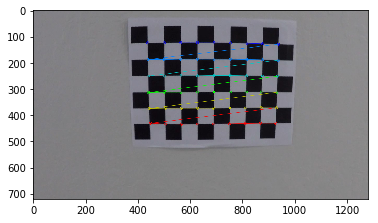

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pickle
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
#images = glob.glob('../camera_cal/calibration*.jpg')  This doesn't work, use os.listdir instead

#img_list = os.listdir("camera_cal/")
#img_list = ["camera_cal/" + img for img in img_list]
images = glob.glob('camera_cal/calibration*.jpg')
#print(img_list)

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    #print("fname =", fname, "ret =", ret)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        #cv2.waitKey(500)
        
        # save the image in assigned output_images folder
        #pos = fname.rfind('/')
        #mpimg.imsave("output_images/" + fname[pos+1:], img)



## 2. Apply a distortion correction to raw images

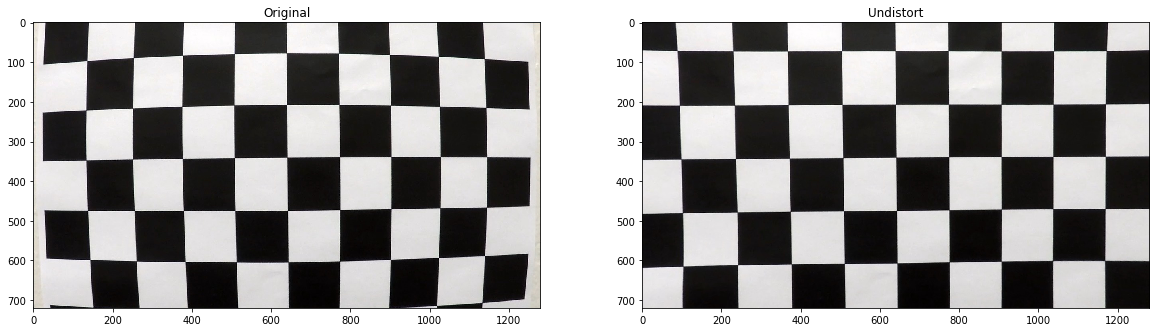

In [3]:

# calibrate camera to get mtx and dist
img1 = mpimg.imread('camera_cal/calibration1.jpg')
img1_size = (img1.shape[1], img1.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img1_size, None, None)

# save mtx and dist for future use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("camera_cal/wide_dist_pickle.p", "wb"))

def undistort(img):
    """undistort image and return undist"""
    camera_coeff = pickle.load(open("camera_cal/wide_dist_pickle.p", "rb"))
    mtx = camera_coeff["mtx"]
    dist = camera_coeff["dist"]
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

undist_img1 = undistort(img1)

# show and compare the images!
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title("Original")
ax1.imshow(img1)
ax2.set_title("Undistort")
ax2.imshow(undist_img1)

# loop through all images and save them in output_images folder, name with format "undist_calibration1.jpg"
for fname in images:
    img = mpimg.imread(fname)
    undist = undistort(img)
    #pos = fname.rfind('/')
    #mpimg.imsave("output_images/" + "undist_" + fname[pos+1:], undist)


## 3. Create a thresholded binary image

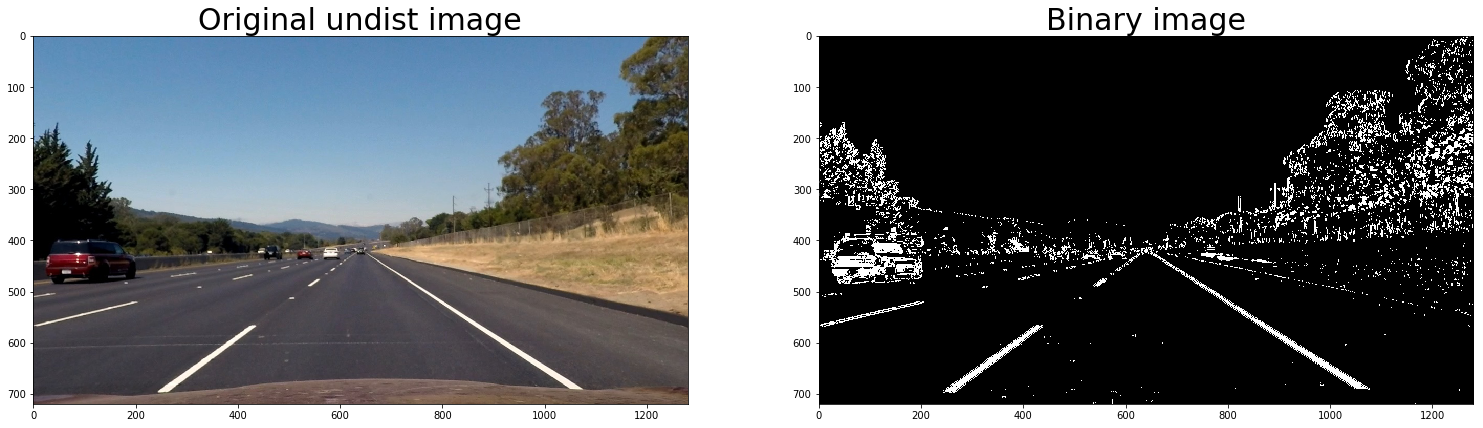

In [4]:
def create_binary(img, sx_thresh = (20, 100), s_thresh = (150, 255)):
    img = np.copy(img) # should be undistorted image!
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS) # convert to HLS
    s_channel = hls[:, :, 2]
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    #sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # s channel threshold
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # x gradient threshold
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    binary = np.zeros_like(sxbinary)
    binary[(s_binary == 1) | (sxbinary == 1)] = 1
    combined_binary = 255*np.dstack((binary,binary,binary)).astype('uint8')
    return combined_binary

test_img = mpimg.imread('test_images/straight_lines2.jpg')
undist_img = undistort(test_img)
binary_img = create_binary(undist_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original undist image', fontsize=30)
ax1.imshow(undist_img)

ax2.set_title('Binary image', fontsize=30)
ax2.imshow(binary_img, cmap="gray")
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# images = glob.glob('test_images/test*.jpg')
# for fname in images:
#     img = mpimg.imread(fname)
#     undist_img = undistort(img)
#     binary_img = create_binary(undist_img)
#     pos = fname.rfind('/')
#     mpimg.imsave("output_images/" + "binary_" + fname[pos+1:], binary_img)


## 4. Apply a perspective transform to rectify binary image

(720, 1280, 3)


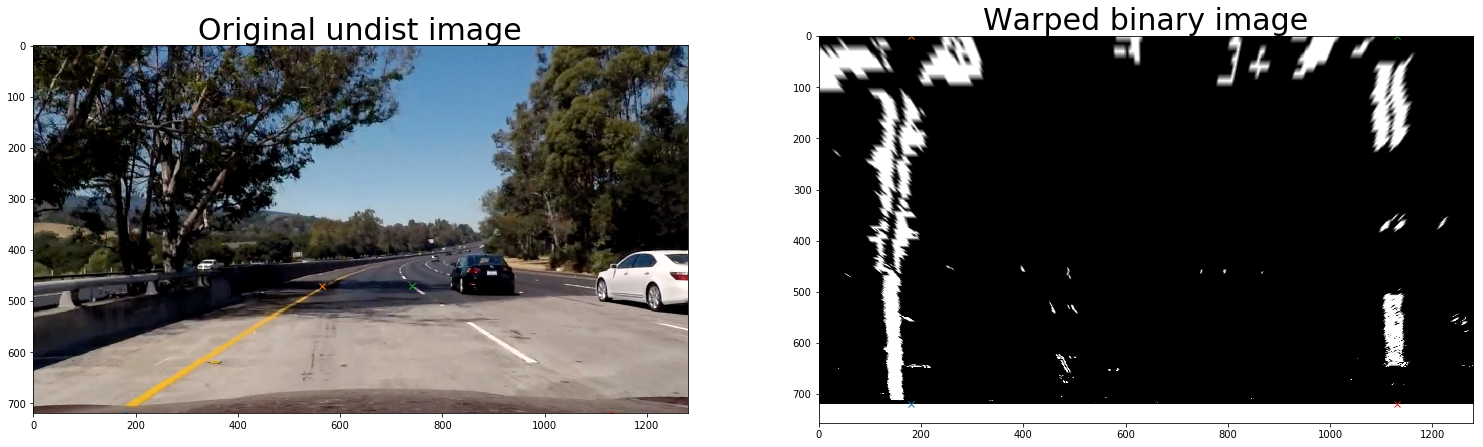

In [15]:
test_img = mpimg.imread('test_images/test5.jpg') # straight_lines1
undist_test_img = undistort(test_img)
#plt.imshow(test_img5)
print(test_img.shape)
# select 4 sourse points as shown

# plt.plot(170,720,'x')
# plt.plot(560,470,'x')
# plt.plot(750,470,'x')
# plt.plot(1170,720,'x')

corners = np.float32([[165, 720], [570, 470], [740, 470], [1135, 720]])

def warp(img, inverse=False):
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [corners[0],
         corners[1],
         corners[2],
         corners[3]])
    
    dst = np.float32([
        [150, 720], 
        [150, 0],                         
        [1130, 0],            
        [1130, 720]])

    if not inverse:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped

binary_img = create_binary(undist_test_img)
warped_binary_img = warp(binary_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original undist image', fontsize=30)
ax1.plot(180,720,'x')
ax1.plot(565,470,'x')
ax1.plot(740,470,'x')
ax1.plot(1130,720,'x')
ax1.imshow(undist_test_img)

ax2.set_title('Warped binary image', fontsize=30)
plt.imshow(warped_binary_img)
ax2.plot(180,720,'x')
ax2.plot(180,0,'x')
ax2.plot(1130,0,'x')
ax2.plot(1130,720,'x')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# images = glob.glob('test_images/straight_lines*.jpg')
# for fname in images:
#     img = mpimg.imread(fname)
#     undist_img = undistort(img)
#     binary_img = create_binary(undist_img)
#     warped_binary_img = warp(binary_img)
#     pos = fname.rfind('/')
#     mpimg.imsave("output_images/" + "warped_binary_" + fname[pos+1:], warped_binary_img)


## 5. Detect lane pixels and fit to find the lane boundary

[  1.03435452e-04  -9.66587217e-02   1.66911059e+02]
[ -2.14895294e-04   1.79052674e-01   1.09280521e+03]


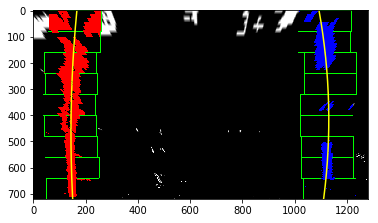

In [16]:
def find_lane_pixels(binary_warped):
    
    binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_RGB2GRAY)
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy < win_y_high) & (nonzeroy >= win_y_low) 
        & (nonzerox < win_xleft_high) & (nonzerox >= win_xleft_low)).nonzero()[0]
        
        good_right_inds = ((nonzeroy < win_y_high) & (nonzeroy >= win_y_low) 
        & (nonzerox < win_xright_high) & (nonzerox >= win_xright_low)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, img = find_lane_pixels(binary_warped)
    out_img = np.copy(img)

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return left_fit, right_fit, out_img

left_fit, right_fit, line_img = fit_polynomial(warped_binary_img)
plt.imshow(line_img)
mpimg.imsave("output_images/fit_polynomial_test5.jpg", line_img)
print(left_fit)
print(right_fit)



## 6. Determine the curvature of the lane and vehicle position with respect to center

In [7]:
def curvature(left_fit, right_fit, binary_warped):
    ploty = np.linspace(0,binary_warped.shape[0] -1 , binary_warped.shape[0])
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700

    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    center_image = 640
    center = (lane_center - center_image)*xm_per_pix
 
    return left_curverad, right_curverad, center

left_cur, right_cur, center = curvature(left_fit, right_fit, line_img)
print("left_curvature =", left_cur, "m,", "right_curvature =", right_cur, "m")
print("position from center =", center, "m")

left_curvature = 1587.82580856 m, right_curvature = 764.529043477 m
position from center = -0.0537410877603 m


## 7. Warp the detected lane boundaries back onto the original image and visualize it!

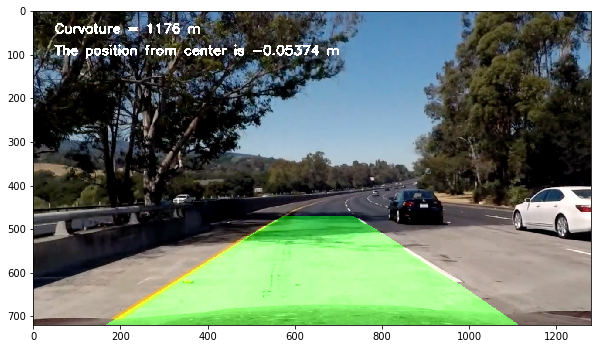

In [8]:
def add_info(img, left_cur, right_cur, center):
    
    avg_cur = (left_cur + right_cur) / 2
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Curvature = %d m' %avg_cur, (50,50), font, 1, (255, 255, 255), 3)
    cv2.putText(img, 'The position from center is %.5f m' %center, (50, 100), font, 1, (255, 255, 255), 3)

def draw_lane_area(undist, binary_warped, left_fit, right_fit, left_cur, right_cur, center):
    
    binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_RGB2GRAY)
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero,warp_zero,warp_zero))
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # draw lane area on warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    warp_back = warp(color_warp, True)
    # draw area on original image
    result = cv2.addWeighted(undist, 1, warp_back, 0.5, 0)
    add_info(result, left_cur, right_cur, center)
    return result

lane_detected_img = draw_lane_area(undist_test_img, warped_binary_img, left_fit, right_fit, left_cur, right_cur, center)
plt.figure(figsize = (10,10))
plt.imshow(lane_detected_img)

## 8. Process test images and video

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:55<00:00,  4.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 24s, sys: 22 s, total: 2min 46s
Wall time: 4min 58s


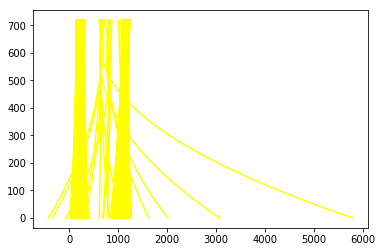

In [9]:
def process_pipeline(image):
    """build the code pipeline of function flow"""
    undist_img = undistort(image)
    binary_img = create_binary(undist_img)
    warped_binary_img = warp(binary_img)
    left_fit, right_fit, line_img = fit_polynomial(warped_binary_img)
    left_cur, right_cur, center = curvature(left_fit, right_fit, line_img)
    lane_detected_img = draw_lane_area(undist_img, warped_binary_img, left_fit, right_fit, left_cur, right_cur, center)
    return lane_detected_img

# loop through all test images and save them in output_images
# images = glob.glob('test_images/test*.jpg')
# for fname in images:
#     image = mpimg.imread(fname)
#     result = process_pipeline(image)
#     plt.imshow(result)
#     pos = fname.rfind('/')
#     mpimg.imsave("output_images/" + "line_detected_" + fname[pos+1:], result)

from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")
out_clip = clip.fl_image(process_pipeline) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [01:43<00:00,  4.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 50.4 s, sys: 7.11 s, total: 57.5 s
Wall time: 1min 46s


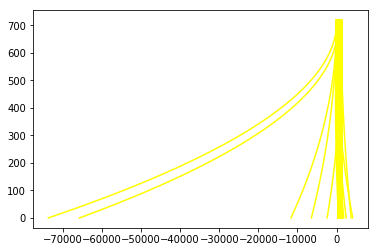

In [11]:
output2 = 'challenge_video_output.mp4'
clip2 = VideoFileClip("challenge_video.mp4")
out_clip2 = clip2.fl_image(process_pipeline) #NOTE: this function expects color images!!
%time out_clip2.write_videofile(output2, audio=False)